In [1]:
from theano.sandbox import cuda

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

Using Theano backend.


In [3]:
path = '/home/ubuntu/fisheries/data/fish/'

In [4]:
batch_size = 64

In [5]:
batches = get_batches(path+'train', batch_size=batch_size)
val_batches = get_batches(path+'valid', batch_size=batch_size*2, shuffle=False)

Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.


In [6]:
(val_classes, trn_classes, val_labels, trn_labels, val_filenames, filenames, test_filenames)=get_classes(path)

Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.
Found 13153 images belonging to 1 classes.


In [7]:
raw_filenames = [f.split('/')[-1] for f in filenames]
raw_val_filenames = [f.split('/')[-1] for f in val_filenames]
raw_test_filenames = [f.split('/')[-1] for f in test_filenames]

In [8]:
trn = load_array(path+'results/trn_640.dat')
val = load_array(path+'results/val_640.dat')

In [9]:
conv_val_feat = load_array(path+'results/conv_val_640.dat')
conv_trn_feat = load_array(path+'results/conv_trn_640.dat')

In [10]:
vgg640 = Vgg16BN((360, 640)).model
vgg640.pop()
vgg640.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 360, 640)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 362, 642)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 360, 640)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 362, 642)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [11]:
conv_layers,_ = split_at(vgg640, Convolution2D)

You can ignore the followling 3 cells, I cannot get the test data, it ran out of memory, not sure how to predict the result, any ideas? 

In [ ]:
test = get_data(path+'test', (360,640))

Found 13153 images belonging to 1 classes.


In [ ]:
vgg640.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
conv_test_feat = vgg640.predict(test, batch_size=32, verbose=1)

## Bound Box

In [27]:
sizes = [PIL.Image.open(path+'train/'+f).size for f in filenames]

In [28]:
val_sizes = [PIL.Image.open(path+'valid/'+f).size for f in val_filenames]

In [29]:
import ujson as json

In [30]:
anno_classes = ['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft']

In [31]:
bb_json = {}
for c in anno_classes:
    j = json.load(open('{}annos/{}_labels.json'.format(path, c), 'r'))
    for l in j:
        if 'annotations' in l.keys() and len(l['annotations']) > 0:
            bb_json[l['filename'].split('/')[-1]] = sorted(l['annotations'], key=lambda x : x['height']*x['width'])[-1]

In [32]:
bb_json['img_04908.jpg']

{u'class': u'rect',
 u'height': 246.75000000000074,
 u'width': 432.8700000000013,
 u'x': 465.3000000000014,
 u'y': 496.32000000000147}

In [33]:
file2idx = {o:i for i,o in enumerate(raw_filenames)}
val_file2idx = {o:i for i,o in enumerate(raw_val_filenames)}

In [34]:
empty_bbox = {'height': 0., 'width': 0., 'x': 0., 'y': 0.}

In [35]:
for f in raw_filenames:
    if f not in bb_json.keys(): bb_json[f] = empty_bbox
        
for f in raw_val_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox

In [36]:
bb_params = ['height', 'width', 'x', 'y']
def convert_bb(bb, size):
    bb = [bb[p] for p in bb_params]
    conv_x = 640./ size[0]
    conv_y = 360./ size[1]
    bb[0] = bb[0] * conv_y
    bb[1] = bb[1] * conv_x
    bb[2] = max(bb[2]*conv_x, 0)
    bb[3] = max(bb[3]*conv_y, 0)
    return bb

In [37]:
trn_bbox = np.stack([convert_bb(bb_json[f],s) for f,s in zip(raw_filenames, sizes)], ).astype(np.float32)
val_bbox = np.stack([convert_bb(bb_json[f],s) for f,s in zip(raw_val_filenames, val_sizes)], ).astype(np.float32)

In [38]:
def create_rec(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)

def show_bb(i):
    bb = val_bbox[i]
    plot(val[i])
    plt.gca().add_patch(create_rec(bb))

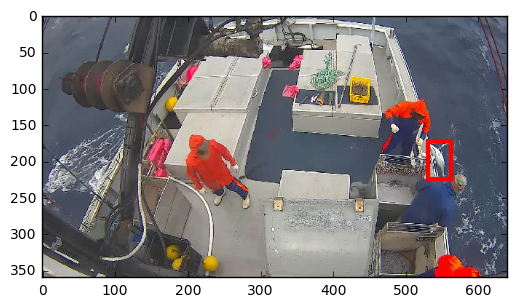

In [34]:
show_bb(0)

## New architecture

In [12]:
nf=128; p=0.

In [13]:
def get_bb_model():
    
    inp = Input(conv_layers[-1].output_shape[1:])
    x = BatchNormalization(axis=1)(inp)
    x = Convolution2D(nf, 3, 3, activation='relu', border_mode='same')(x)
    x = BatchNormalization(axis=1)(x)
    x = Convolution2D(nf, 3, 3, activation='relu', border_mode='same')(x)
    x = BatchNormalization(axis=1)(x)
    x = Convolution2D(nf, 3, 3, activation='relu', border_mode='same')(x)
    x = BatchNormalization(axis=1)(x)
    x = Convolution2D(8, 3, 3, border_mode='same')(x)
    x_bb = Flatten()(x)
    x_bb = Dense(4, name='bb')(x_bb)
    x_class = GlobalAveragePooling2D()(x)
    x_class = Activation('softmax')(x_class)
    
    return Model(inp, [x_bb, x_class])

In [14]:
fcn_bb_model = get_bb_model()

th


In [100]:
fcn_bb_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 512, 22, 40)   0                                            
____________________________________________________________________________________________________
batchnormalization_9 (BatchNormal(None, 512, 22, 40)   1024        input_3[0][0]                    
____________________________________________________________________________________________________
convolution2d_22 (Convolution2D) (None, 128, 22, 40)   589952      batchnormalization_9[0][0]       
____________________________________________________________________________________________________
batchnormalization_10 (BatchNorma(None, 128, 22, 40)   256         convolution2d_22[0][0]           
___________________________________________________________________________________________

In [15]:
fcn_bb_model.compile(Adam(lr=0.001), loss=['mse', 'categorical_crossentropy'], metrics=['accuracy'], loss_weights=[.001, 1.])

In [102]:
fcn_bb_model.fit(conv_trn_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=2, 
             validation_data=(conv_val_feat, [val_bbox,val_labels]))

Train on 3277 samples, validate on 500 samples
Epoch 1/2
3277/3277 [==============================] - 25s - loss: 7.8636 - bb_loss: 6366.2580 - activation_3_loss: 1.4973 - bb_acc: 0.6494 - activation_3_acc: 0.5233 - val_loss: 9.9863 - val_bb_loss: 5653.9458 - val_activation_3_loss: 4.3324 - val_bb_acc: 0.6780 - val_activation_3_acc: 0.4460
Epoch 2/2
3277/3277 [==============================] - 25s - loss: 2.4676 - bb_loss: 1807.8647 - activation_3_loss: 0.6597 - bb_acc: 0.7492 - activation_3_acc: 0.8117 - val_loss: 4.4846 - val_bb_loss: 2961.5236 - val_activation_3_loss: 1.5230 - val_bb_acc: 0.7220 - val_activation_3_acc: 0.5300


In [104]:
fcn_bb_model.optimizer.lr = 1e-5

In [105]:
fcn_bb_model.fit(conv_trn_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=4, 
             validation_data=(conv_val_feat, [val_bbox,val_labels]))

Train on 3277 samples, validate on 500 samples
Epoch 1/4
3277/3277 [==============================] - 25s - loss: 1.4880 - bb_loss: 1131.6004 - activation_3_loss: 0.3564 - bb_acc: 0.7870 - activation_3_acc: 0.9115 - val_loss: 2.6640 - val_bb_loss: 1958.6424 - val_activation_3_loss: 0.7053 - val_bb_acc: 0.7480 - val_activation_3_acc: 0.7580
Epoch 2/4
3277/3277 [==============================] - 25s - loss: 1.1235 - bb_loss: 885.4346 - activation_3_loss: 0.2380 - bb_acc: 0.7983 - activation_3_acc: 0.9396 - val_loss: 1.9070 - val_bb_loss: 1434.8762 - val_activation_3_loss: 0.4721 - val_bb_acc: 0.7640 - val_activation_3_acc: 0.8480
Epoch 3/4
3277/3277 [==============================] - 25s - loss: 0.7561 - bb_loss: 609.3798 - activation_3_loss: 0.1467 - bb_acc: 0.8166 - activation_3_acc: 0.9692 - val_loss: 1.5650 - val_bb_loss: 1341.9097 - val_activation_3_loss: 0.2231 - val_bb_acc: 0.7800 - val_activation_3_acc: 0.9360
Epoch 4/4
3277/3277 [==============================] - 25s - loss: 0.5

In [106]:
fcn_bb_model.fit(conv_trn_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=1, 
             validation_data=(conv_val_feat, [val_bbox,val_labels]))

Train on 3277 samples, validate on 500 samples
Epoch 1/1
3277/3277 [==============================] - 25s - loss: 0.4352 - bb_loss: 378.2675 - activation_3_loss: 0.0569 - bb_acc: 0.8377 - activation_3_acc: 0.9918 - val_loss: 1.4457 - val_bb_loss: 1301.5523 - val_activation_3_loss: 0.1441 - val_bb_acc: 0.7760 - val_activation_3_acc: 0.9580


In [107]:
fcn_bb_model.save_weights(path+'models/fcn_bb_7e.h5')

In [109]:
fcn_bb_model.fit(conv_trn_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=1, 
             validation_data=(conv_val_feat, [val_bbox,val_labels]))

Train on 3277 samples, validate on 500 samples
Epoch 1/1
3277/3277 [==============================] - 25s - loss: 0.3071 - bb_loss: 273.6810 - activation_3_loss: 0.0334 - bb_acc: 0.8450 - activation_3_acc: 0.9973 - val_loss: 1.3543 - val_bb_loss: 1227.1232 - val_activation_3_loss: 0.1272 - val_bb_acc: 0.7720 - val_activation_3_acc: 0.9620


In [110]:
fcn_bb_model.save_weights(path+'models/fcn_bb_9e.h5')

In [111]:
fcn_bb_model.fit(conv_trn_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=1, 
             validation_data=(conv_val_feat, [val_bbox,val_labels]))

Train on 3277 samples, validate on 500 samples
Epoch 1/1
3277/3277 [==============================] - 25s - loss: 0.2828 - bb_loss: 258.3640 - activation_3_loss: 0.0244 - bb_acc: 0.8419 - activation_3_acc: 0.9997 - val_loss: 1.3981 - val_bb_loss: 1274.4607 - val_activation_3_loss: 0.1236 - val_bb_acc: 0.7800 - val_activation_3_acc: 0.9720


In [112]:
fcn_bb_model.save_weights(path+'models/fcn_bb_10e.h5')

In [113]:
fcn_bb_model.fit(conv_trn_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=1, 
             validation_data=(conv_val_feat, [val_bbox,val_labels]))

Train on 3277 samples, validate on 500 samples
Epoch 1/1
3277/3277 [==============================] - 25s - loss: 0.2934 - bb_loss: 267.5068 - activation_3_loss: 0.0259 - bb_acc: 0.8471 - activation_3_acc: 0.9985 - val_loss: 1.3833 - val_bb_loss: 1264.1682 - val_activation_3_loss: 0.1191 - val_bb_acc: 0.7660 - val_activation_3_acc: 0.9700


In [116]:
fcn_bb_model.fit(conv_trn_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=1, 
             validation_data=(conv_val_feat, [val_bbox,val_labels]))

Train on 3277 samples, validate on 500 samples
Epoch 1/1
3277/3277 [==============================] - 25s - loss: 0.1881 - bb_loss: 171.1783 - activation_3_loss: 0.0169 - bb_acc: 0.8560 - activation_3_acc: 1.0000 - val_loss: 1.3183 - val_bb_loss: 1193.5042 - val_activation_3_loss: 0.1248 - val_bb_acc: 0.7620 - val_activation_3_acc: 0.9620


In [16]:
fcn_bb_model.load_weights(path+'models/fcn_bb_10e.h5')

## Visualization

In [17]:
l = fcn_bb_model.layers
conv_fn = K.function([l[0].input, K.learning_phase()], l[-5].output)

In [18]:
def get_cm2(inp, label):
    conv = conv_fn([inp,0])[0, label]
    return scipy.misc.imresize(conv, (360,640))

In [19]:
inp = np.expand_dims(conv_val_feat[9], 0)

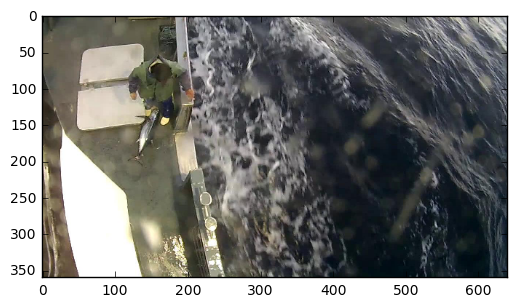

In [20]:
plt.imshow(to_plot(val[9]))

In [21]:
cm = get_cm2(inp, 0)

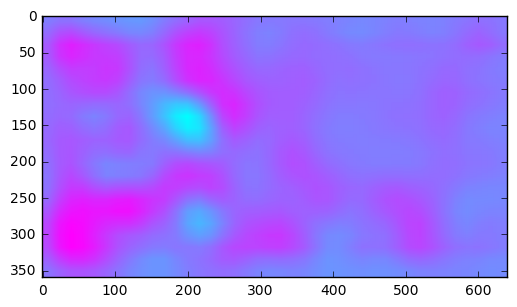

In [22]:
plt.imshow(cm, cmap="cool")

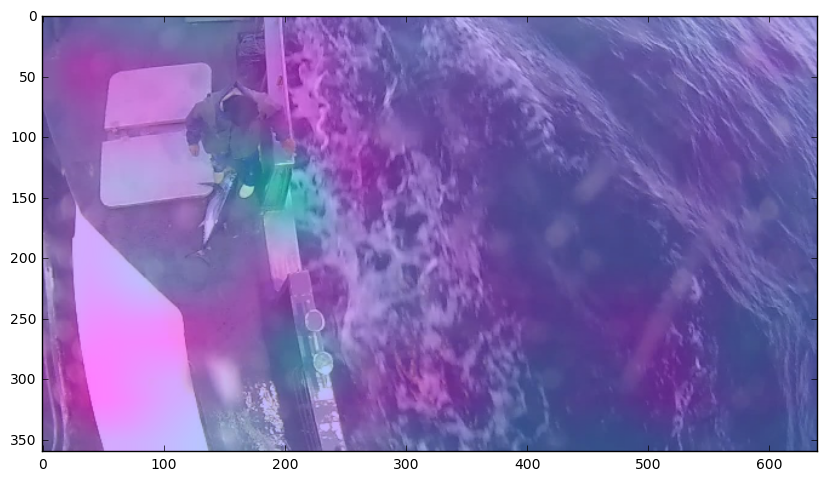

In [23]:
plt.figure(figsize=(10,10))
plot(val[9])
plt.imshow(cm, cmap="cool", alpha=0.5)

In [24]:
pred = fcn_bb_model.predict(conv_val_feat[0:10])

In [25]:
def show_bb_pred(i):
    bb = val_bbox[i]
    bb_pred = pred[0][i] #predict[0]是bbox的预测
    plt.figure(figsize=(6,6))
    plot(val[i])
    ax = plt.gca()
    ax.add_patch(create_rec(bb_pred, 'yellow'))
    ax.add_patch(create_rec(bb))

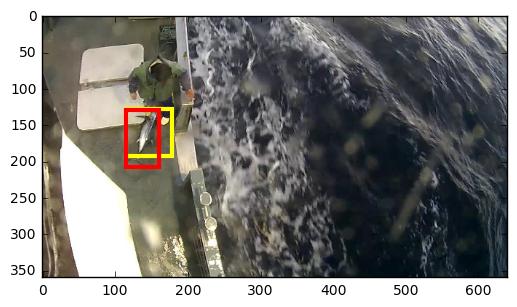

In [39]:
show_bb_pred(9)

### Submit

In [118]:
conv_test_feat = load_array(path+'results/conv_test_640.dat')

In [119]:
def do_clip(arr, mx): return np.clip(arr, (1-mx)/7, mx)

In [120]:
preds = fcn_bb_model.predict(conv_test_feat, batch_size=batch_size)

In [121]:
preds = preds[1]

In [122]:
preds[0]

array([  9.7947e-01,   2.5206e-03,   7.1483e-03,   4.9680e-04,   9.3528e-03,   1.6253e-04,
         6.5789e-04,   1.9254e-04], dtype=float32)

In [123]:
preds.shape

(1000, 8)

In [124]:
subm = do_clip(preds, 0.82)

In [125]:
subm[:5]

array([[ 0.82  ,  0.0257,  0.0257,  0.0257,  0.0257,  0.0257,  0.0257,  0.0257],
       [ 0.7103,  0.0257,  0.0257,  0.0257,  0.0411,  0.0414,  0.1614,  0.0257],
       [ 0.0313,  0.0257,  0.0257,  0.0257,  0.82  ,  0.0257,  0.0365,  0.0257],
       [ 0.7733,  0.0257,  0.0257,  0.0257,  0.0257,  0.0564,  0.0257,  0.1172],
       [ 0.82  ,  0.0257,  0.0257,  0.0257,  0.0257,  0.0257,  0.0257,  0.0257]], dtype=float32)

In [126]:
subm_name = path+'results/subm_bb_2.gz'

In [127]:
classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

In [128]:
submission = pd.DataFrame(subm, columns=classes)
submission.insert(0, 'image', raw_test_filenames)
submission.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_06237.jpg,0.820000,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714
1,img_06893.jpg,0.710255,0.025714,0.025714,0.025714,0.041088,0.041368,0.161359,0.025714
2,img_02082.jpg,0.031325,0.025714,0.025714,0.025714,0.820000,0.025714,0.036455,0.025714
3,img_06261.jpg,0.773309,0.025714,0.025714,0.025714,0.025714,0.056359,0.025714,0.117201
4,img_03628.jpg,0.820000,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714


In [129]:
submission.to_csv(subm_name, index=False, compression='gzip')

In [130]:
FileLink(subm_name)

/home/ubuntu/fisheries/data/fish/results/subm_bb_2.gz